In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import pickle

In [ ]:
np.random.seed(42)

n_samples = 1000
df = pd.DataFrame({
    "tourist_id": np.random.randint(1, 200, n_samples),
    "zone_risk_level": np.random.choice([0,1,2], size=n_samples, p=[0.6, 0.3, 0.1]), # 0=Safe,1=Medium,2=High
    "deviation_from_route": np.random.choice([0,1], size=n_samples, p=[0.8, 0.2]),
    "inactivity_duration": np.random.randint(0, 120, n_samples) # minutes
})

df.head()

,tourist_id,zone_risk_level,deviation_from_route,inactivity_duration
0,103,0,0,99
1,180,1,1,30
2,93,1,0,1
3,15,0,1,15
4,107,0,1,8


In [ ]:
def calculate_safety_score(row):
    score = 100
    score -= row['zone_risk_level'] * 20
    score -= row['deviation_from_route'] * 30
    score -= min(row['inactivity_duration'], 60) * 0.5
    return max(score, 0)

df['safety_score'] = df.apply(calculate_safety_score, axis=1)

# Label tourists: Safe (>=50) vs Risky (<50)
df['safety_label'] = np.where(df['safety_score'] >= 50, 0, 1)  # 0=Safe,1=Risky

df.head()

,tourist_id,zone_risk_level,deviation_from_route,inactivity_duration,safety_score,safety_label
0,103,0,0,99,70.0,0
1,180,1,1,30,35.0,1
2,93,1,0,1,79.5,0
3,15,0,1,15,62.5,0
4,107,0,1,8,66.0,0


In [ ]:
X = df[['zone_risk_level','deviation_from_route','inactivity_duration']]
y = df['safety_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n🔹 {name}")
    print(classification_report(y_test, y_pred))


🔹 Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       236
           1       0.98      1.00      0.99        64

    accuracy                           1.00       300
   macro avg       0.99      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


🔹 Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       236
           1       1.00      1.00      1.00        64

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


🔹 Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       236
           1       1.00      1.00      1.00        64

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg     

In [ ]:
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(X)
df['anomaly'] = df['anomaly'].map({1:0, -1:1})

print(df['anomaly'].value_counts())
df[df['anomaly']==1].head()

anomaly
0    950
1     50
Name: count, dtype: int64


,tourist_id,zone_risk_level,deviation_from_route,inactivity_duration,safety_score,safety_label,anomaly
19,2,2,1,87,0.0,1,1
24,192,2,1,2,29.0,1,1
33,170,2,1,53,3.5,1,1
42,55,2,0,117,30.0,1,1
63,199,2,0,2,59.0,0,1


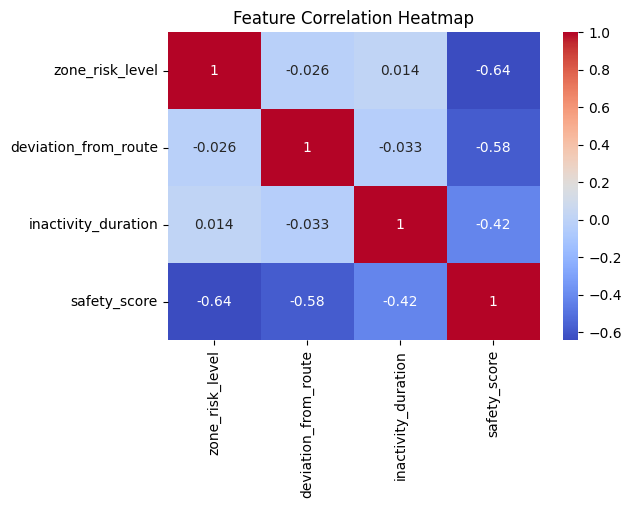

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['zone_risk_level','deviation_from_route','inactivity_duration','safety_score']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
def predict_safety_score(new_data):
    row = pd.Series(new_data)
    score = calculate_safety_score(row)
    label = "Safe" if score >= 50 else "Risky"
    
    features = scaler.transform([[new_data['zone_risk_level'], new_data['deviation_from_route'], new_data['inactivity_duration']]])
    anomaly_flag = iso.predict(features)[0] == -1
    
    return {
        "safety_score": score,
        "risk_label": label,
        "anomaly_flag": anomaly_flag
    }

# Example
print(predict_safety_score({"zone_risk_level": 2, "deviation_from_route": 1, "inactivity_duration": 45}))

{'safety_score': np.float64(7.5), 'risk_label': 'Risky', 'anomaly_flag': np.True_}


c:\Users\deepa\OneDrive\Desktop\SIH\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\deepa\OneDrive\Desktop\SIH\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [9]:
with open("tourist_safety_model.sav", "wb") as f:
    pickle.dump({"scaler": scaler, "iso": iso}, f)